In [82]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
path_to_data = "processed"

In [12]:
data = [os.path.join(path_to_data, x) for x in os.listdir(path_to_data)]
data = [x for x in data if os.path.isfile(x) and ".csv" in x]
print (data)

['processed/bootstrap100.csv', 'processed/bootstrap100_NNI.csv', 'processed/jackknife100_036788.csv', 'processed/jackknife100_05.csv', 'processed/jackknife100_05_NNI.csv', 'processed/jackknife100_067.csv', 'processed/jackknife100_075.csv', 'processed/jackknife100_08.csv', 'processed/jackknife100_083.csv', 'processed/jackknife100_086.csv', 'processed/jackknife200_036788.csv', 'processed/jackknife200_05.csv', 'processed/jackknife200_067.csv', 'processed/jackknife20_05.csv', 'processed/jackknife20_05_NNI.csv', 'processed/jackknife50_05.csv']


In [79]:
class PredictorResultParser:
    regex = re.compile(r"(?P<tree_path>[^;]+);\"(?P<tree_leaves_deep>[^\"]+)\";\"(?P<etalon_leaves_deep>[^\"]+)\";(?P<boot_score>[0-9\.]+)")
    def __init__(self, file_name):
        with open(file_name) as input_data:
            input_data.readline() # pass header
            boot_score = []
            is_true = []
            tree_leaf_deep = []
            etalon_leaf_deep = []
            for line in input_data:
                match = PredictorResultParser.regex.match(line)
                if match:
                    boot_score.append(float(match.group("boot_score")))
                    et_l = match.group("etalon_leaves_deep")
                    is_true.append(0 if et_l == "None" else 1)
                    tree_leaf_deep.append(map(int, match.group("tree_leaves_deep").split(";")))
                    etalon_leaf_deep.append(map(int, et_l.split(";")) if et_l != "None" else [np.nan for i in range(len(tree_leaf_deep[0]))])
                else:
                    print (line)
                    raise Exception("Wrong format of file")
        self.name = os.path.basename(file_name)
        self.is_true = np.array(is_true,  dtype=np.int8)
        self.boot_score = np.array(boot_score, dtype=np.float64)
        self.tree_leaf_deep = np.array(tree_leaf_deep, dtype=np.int64)
        self.etalon_leaf_deep = np.array(etalon_leaf_deep, dtype=np.float64) # nan :(
    
                    
            

In [80]:
example_str = '/HOME/indy/gcg_wif/sas/Trees/2016/ForPaper/Fungi/Selections30/Trees/PQ/bootstrap100/PF00270_14.tre;"10;8;8;8;7;7;5;5;5;8;8;8;8;6;6;6;4;3;3;3;3;2;5;5;4;4;4;2;2;2";"7;7;7;7;7;5;6;6;5;4;4;5;5;4;3;3;3;2;2;2;3;3;3;4;7;7;6;7;7;7";100.0'
regex = re.compile(r"(?P<tree_path>[^;]+);\"(?P<tree_leaves_deep>[^\"]+)\";\"(?P<etalon_leaves_deep>[^\"]+)\";(?P<boot_score>[0-9\.]+)")
print regex.match(example_str).group("etalon_leaves_deep")

7;7;7;7;7;5;6;6;5;4;4;5;5;4;3;3;3;2;2;2;3;3;3;4;7;7;6;7;7;7


In [81]:
predictors = [PredictorResultParser(x) for x in data]

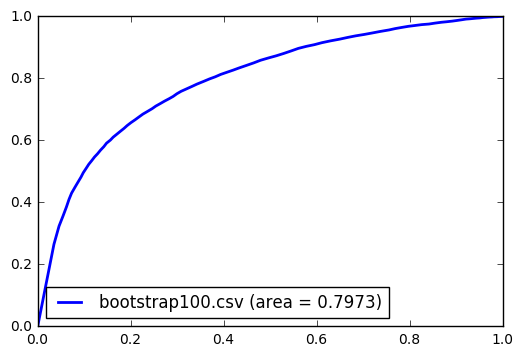

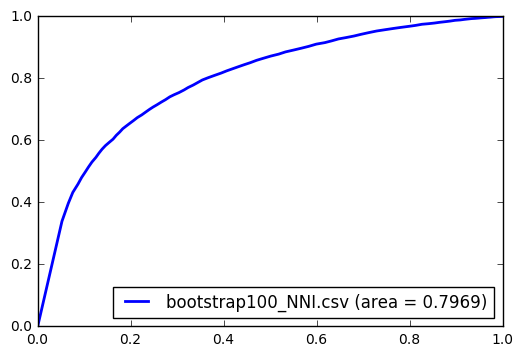

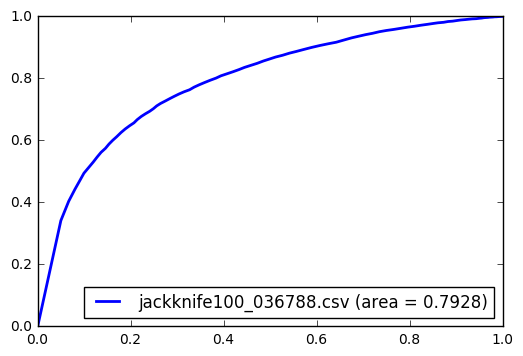

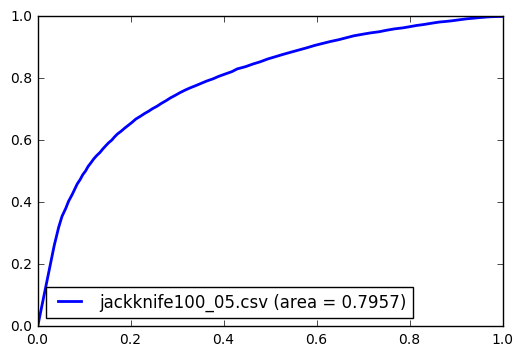

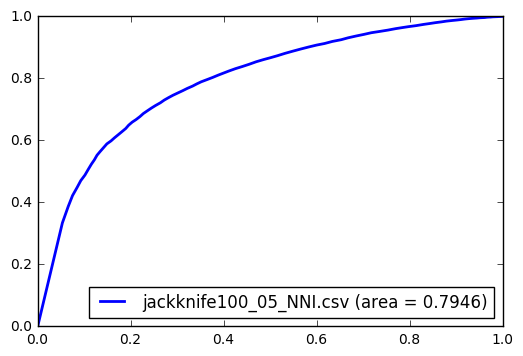

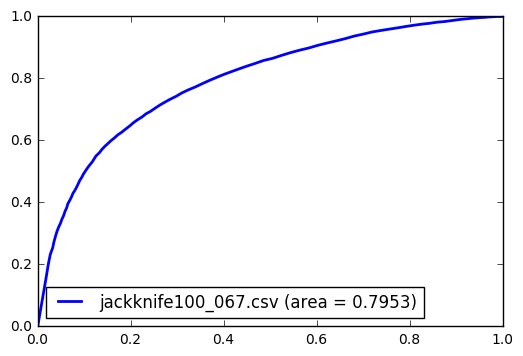

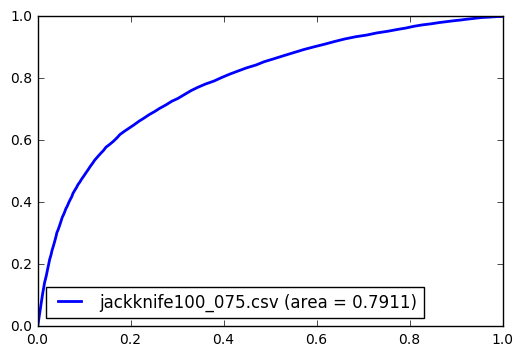

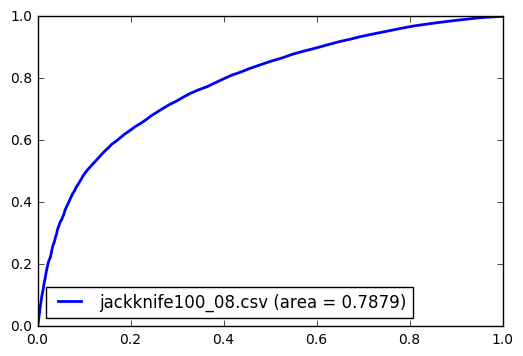

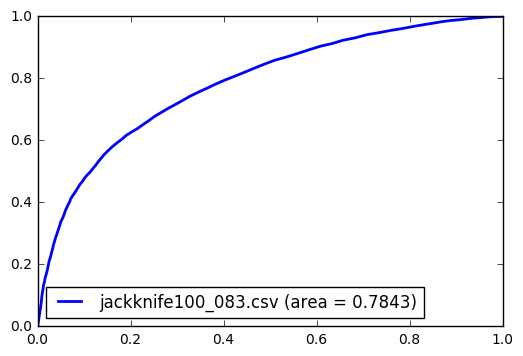

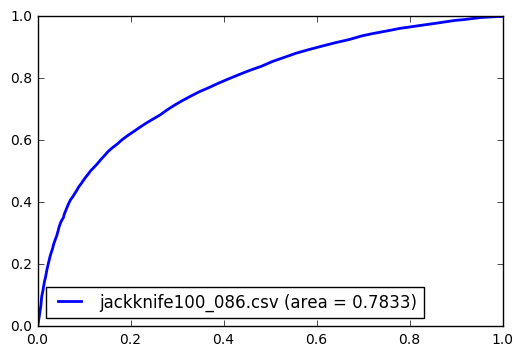

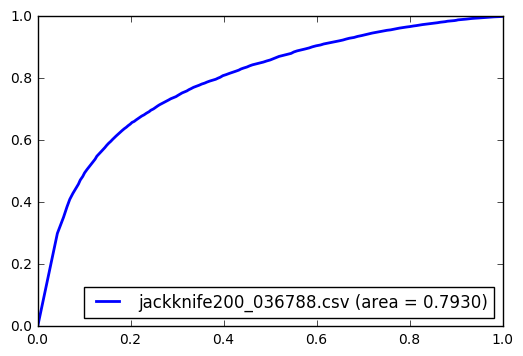

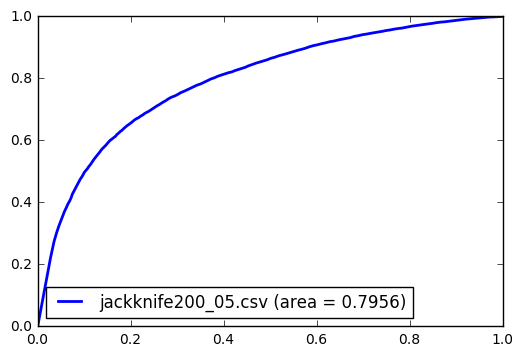

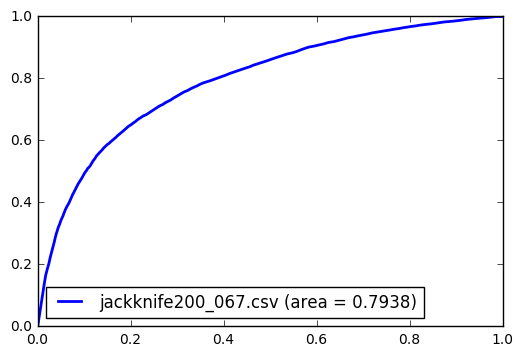

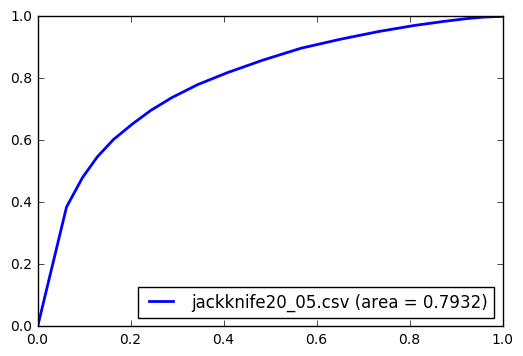

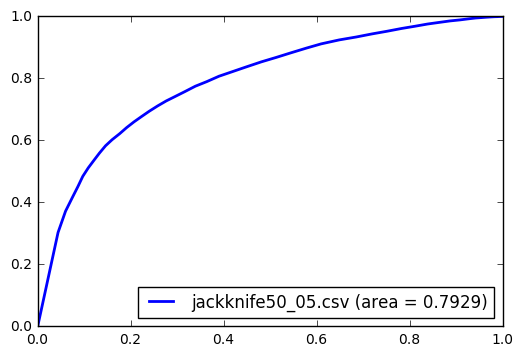

In [92]:
for pred in predictors:
    if pred.is_true.shape[0]:
        fpr, tpr, _ = roc_curve(pred.is_true, pred.boot_score)
        roc_auc = auc(fpr, tpr)
        lw = 2
        plt.plot(fpr, tpr,
             lw=lw, label='{} (area = {:.04f})'.format(pred.name, roc_auc))
        plt.legend(loc="best")
        plt.show()

plt.show()

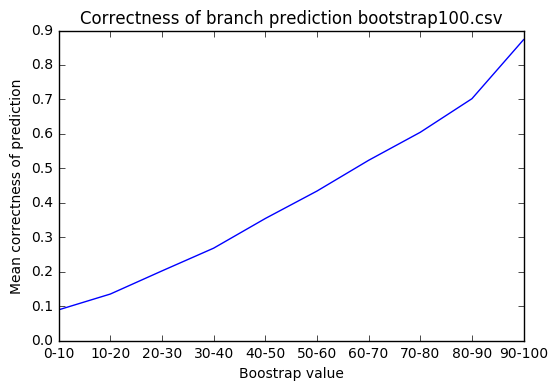

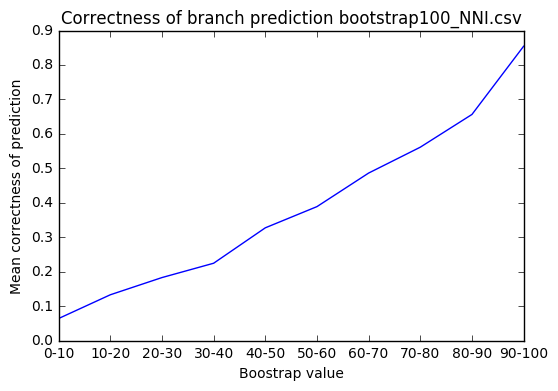

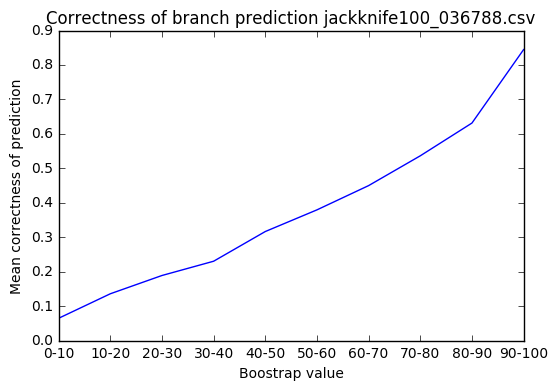

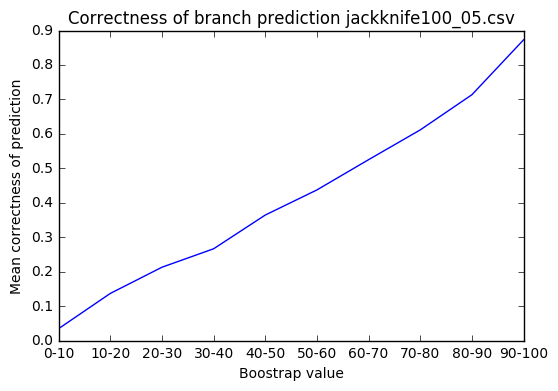

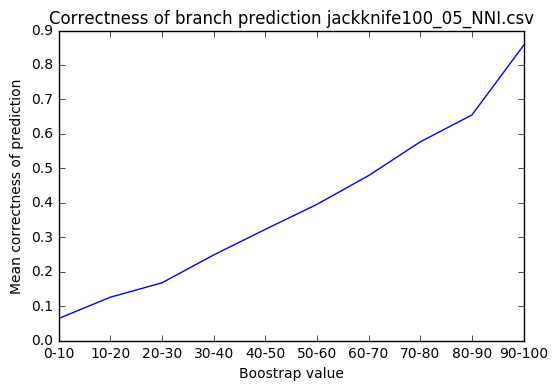

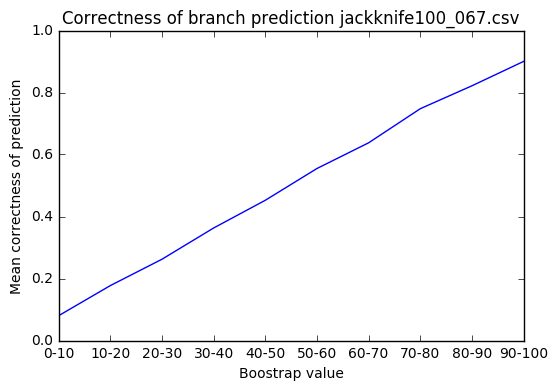

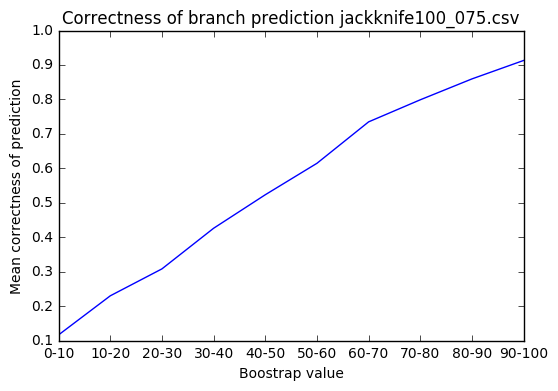

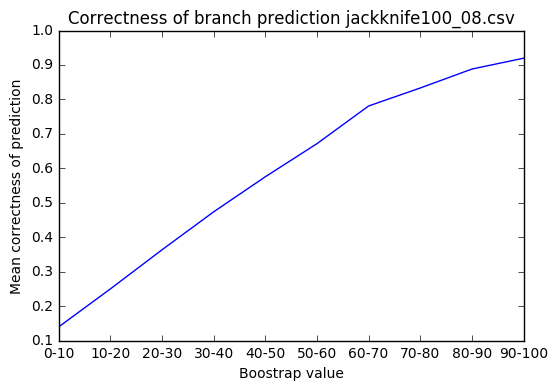

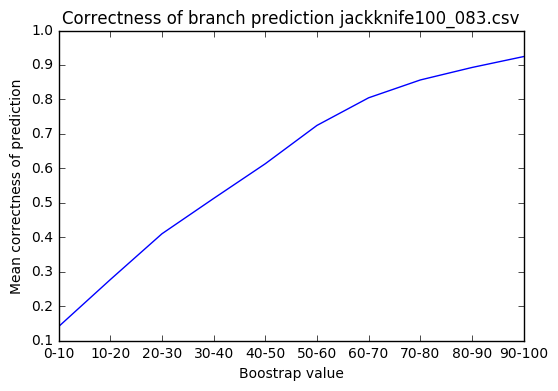

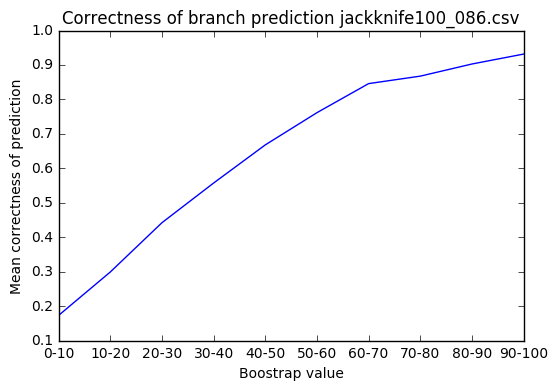

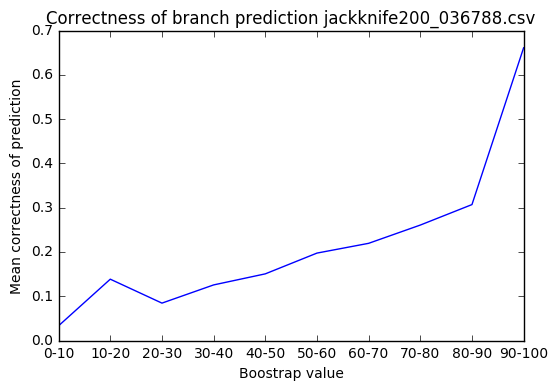

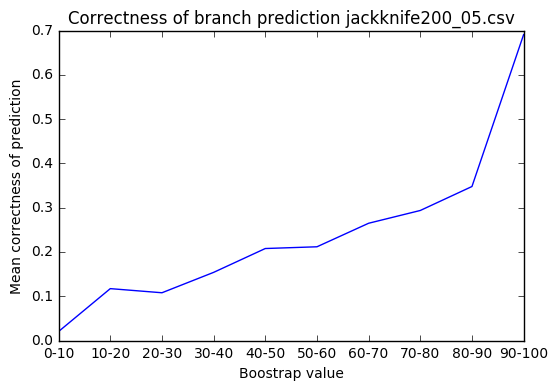

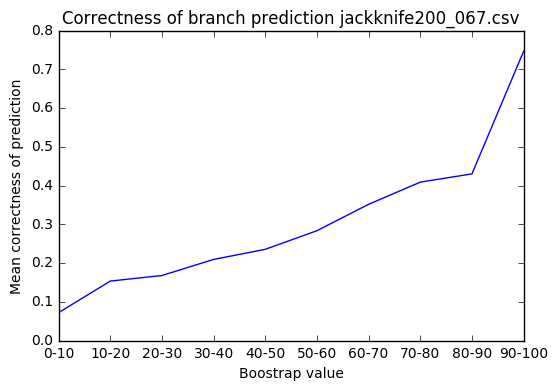

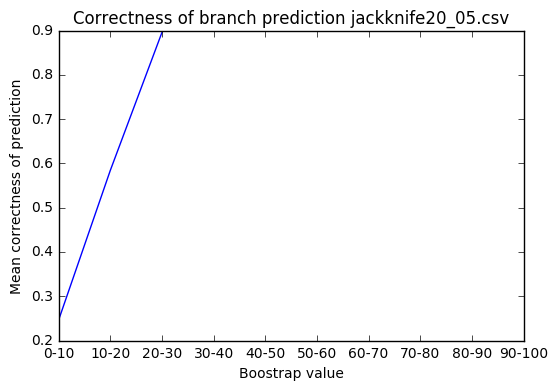

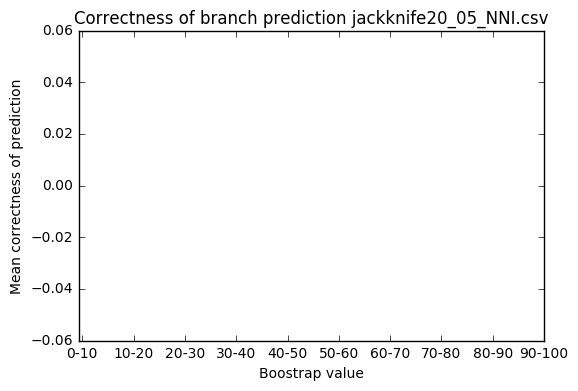

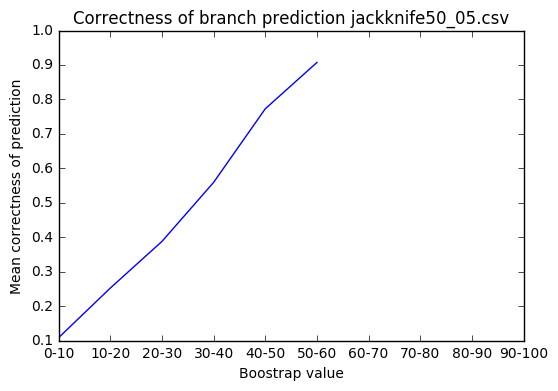

In [98]:

bins = np.linspace(0, 100, 10, endpoint=False)
step = float(bins[1] - bins[0])

for pred in predictors:
    pos = np.digitize(pred.boot_score, bins)
    mean_is_true = np.zeros(len(bins))

    for i, b in enumerate(bins, start = 1):
        mean_is_true[i - 1] = np.mean(pred.is_true[pos == i])

    plt.title("Correctness of branch prediction {}".format(pred.name))
    plt.plot(mean_is_true)
    plt.xlabel("Boostrap value")
    plt.ylabel("Mean correctness of prediction")
    plt.xticks(np.arange(len(mean_is_true)), ["{:.0f}-{:.0f}".format(x * step , (x + 1) * step) for x in xrange(len(mean_is_true))])
    plt.show()    
